In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import torch
import copy

In [2]:
# sys.path.append('../../WatChMaL_analysis_copy/')
sys.path.append('../../WatChMaL/')

In [3]:
# from WatChMaL.watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset import CNNmPMTDataset
from watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset import CNNmPMTDataset

In [4]:
sys.modules[CNNmPMTDataset.__module__]

<module 'watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset' from '../../WatChMaL/watchmal/dataset/cnn_mpmt/cnn_mpmt_dataset.py'>

<h1>Define Plotting Functions</h1>

In [5]:
def plot_event(data, mpmt_pos, old_convention=False, title=None, style="default", cmap=plt.cm.jet, vertical_partition=False,
              padded=False, horizontal_partition=False):
    cmap = copy.copy(cmap)
    if style=="dark_background":
        edgecolor='0.15'
        cmap.set_bad(color='black')
    else:
        edgecolor='0.85'
        cmap.set_bad(color='white')
    data[data==0] = np.nan
    indices = np.indices(data.shape)
    channels = indices[0].flatten()
    positions = indices[1:].reshape(2,-1).astype(np.float64)
    positions += channel_to_position(channels)
    if old_convention:
        positions[1] = max(mpmt_pos[:, 1])-positions[1]
    mpmts = [Circle((pos[1], pos[0]), radius=0.47)
             for pos in mpmt_pos]
    with plt.style.context(style):
        if old_convention:
            figsize = (20,16)
        elif padded:
            figsize = (25,10)
        else:
            figsize = (20,12)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.add_collection(PatchCollection(mpmts, facecolor='none', linewidths=1, edgecolors=edgecolor))
        pmts = ax.scatter(positions[1], positions[0], c=data.flatten(), s=3, cmap=cmap)
        plt.colorbar(pmts)
    if title is not None:
        ax.set_title(title)
    
    #New
    if vertical_partition:
        plt.axvline(x=data.shape[2]-1, c='r')
    
    if horizontal_partition:
        plt.axhline(y=data.shape[1]-1, c='r')

In [6]:
def channel_to_position(channel):
    channel = channel % 19 
    theta = (channel<12)*2*np.pi*channel/12 + ((channel >= 12) & (channel<18))*2*np.pi*(channel-12)/6
    radius = 0.2*(channel<18)+0.2*(channel<12)
    position = [radius*np.cos(theta), radius*np.sin(theta)] # note this is [y, x] or [row, column]
    return position

<h1>Load Data</h1>

In [7]:
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

In [8]:
data_file.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>

In [9]:
data_obj = CNNmPMTDataset(data_path, '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz', is_distributed=False)

<h1>Visualizing the Data</h1>

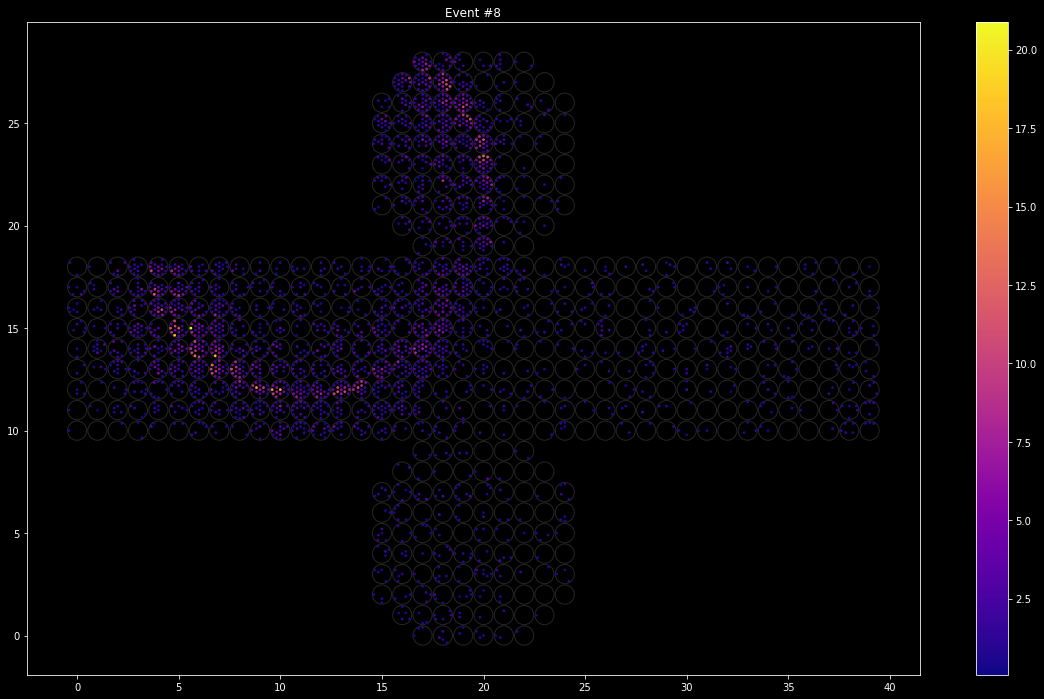

In [10]:
data_short = data_obj.__getitem__(8)['data']
plot_event(data_short, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma)

In [11]:
barrel_rows = data_obj.barrel_rows

In [12]:
data_short[:, barrel_rows, :].shape

torch.Size([19, 9, 40])

In [13]:
transform_data = data_short.clone()
transform_data.shape

torch.Size([19, 29, 40])

In [14]:
transform_data[:, barrel_rows, :] = torch.tensor(np.roll(transform_data[:, barrel_rows, :], 20, 2))

In [15]:
l_index = data_short.shape[2]/2 - 1
r_index = data_short.shape[2]/2

In [16]:
l_endcap_ind = int(l_index - 4)
r_endcap_ind = int(r_index + 4)

In [17]:
top_end_cap = data_short.clone()[:, barrel_rows[-1]+1:, l_endcap_ind:r_endcap_ind+1]

In [18]:
bot_end_cap = data_short.clone()[:, :barrel_rows[0], l_endcap_ind:r_endcap_ind+1]

<h2>Apply Vertical and Horizontal Transformations</h2>

In [19]:
from watchmal.dataset.cnn_mpmt.transformations import vertical_flip, horizontal_flip 

In [20]:
vhflip_top = horizontal_flip(vertical_flip(top_end_cap))
vhlfip_bot = horizontal_flip(vertical_flip(bot_end_cap))

In [21]:
transform_data[:, barrel_rows[-1]+1:, l_endcap_ind : r_endcap_ind+1] = vhflip_top
transform_data[:, :barrel_rows[0], l_endcap_ind : r_endcap_ind+1] = vhlfip_bot

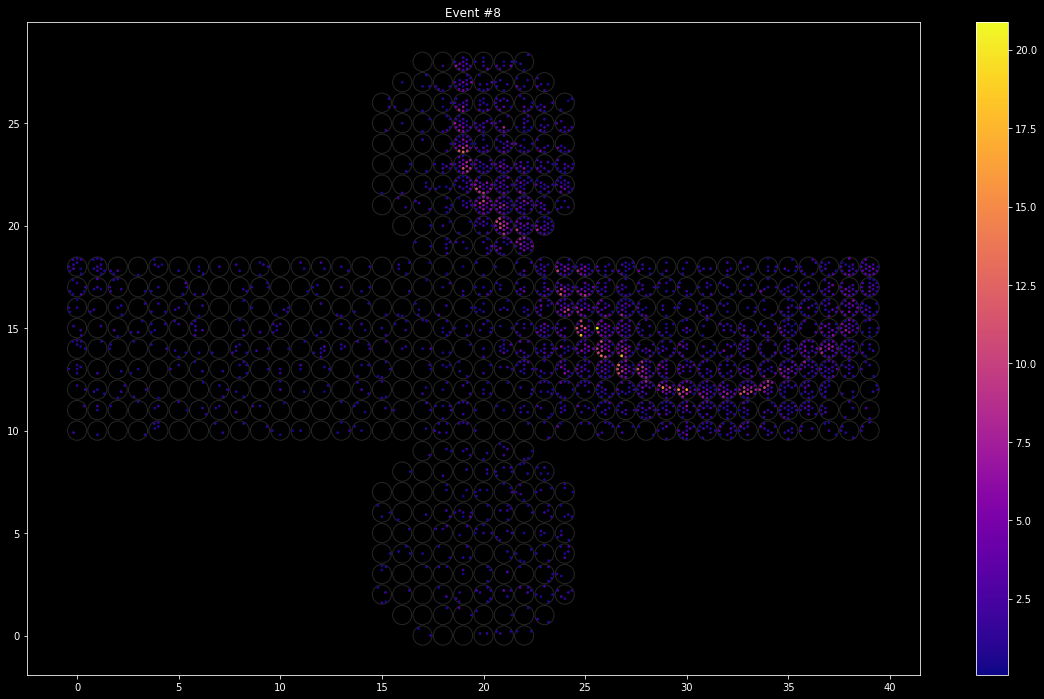

In [22]:
plot_event(transform_data, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma,
        padded=False)

In [23]:
def rotation180(data, barrel_rows):
    transform_data = data_short.clone()
    transform_data[:, barrel_rows, :] = torch.tensor(np.roll(transform_data[:, barrel_rows, :], 20, 2))
    
    l_index = data_short.shape[2]/2 - 1
    r_index = data_short.shape[2]/2

    l_endcap_ind = int(l_index - 4)
    r_endcap_ind = int(r_index + 4)
    
    top_end_cap = data_short.clone()[:, barrel_rows[-1]+1:, l_endcap_ind:r_endcap_ind+1]
    bot_end_cap = data_short.clone()[:, :barrel_rows[0], l_endcap_ind:r_endcap_ind+1]
    
    vhflip_top = horizontal_flip(vertical_flip(top_end_cap))
    vhlfip_bot = horizontal_flip(vertical_flip(bot_end_cap))
    
    transform_data[:, barrel_rows[-1]+1:, l_endcap_ind : r_endcap_ind+1] = vhflip_top
    transform_data[:, :barrel_rows[0], l_endcap_ind : r_endcap_ind+1] = vhlfip_bot
    
    return transform_data

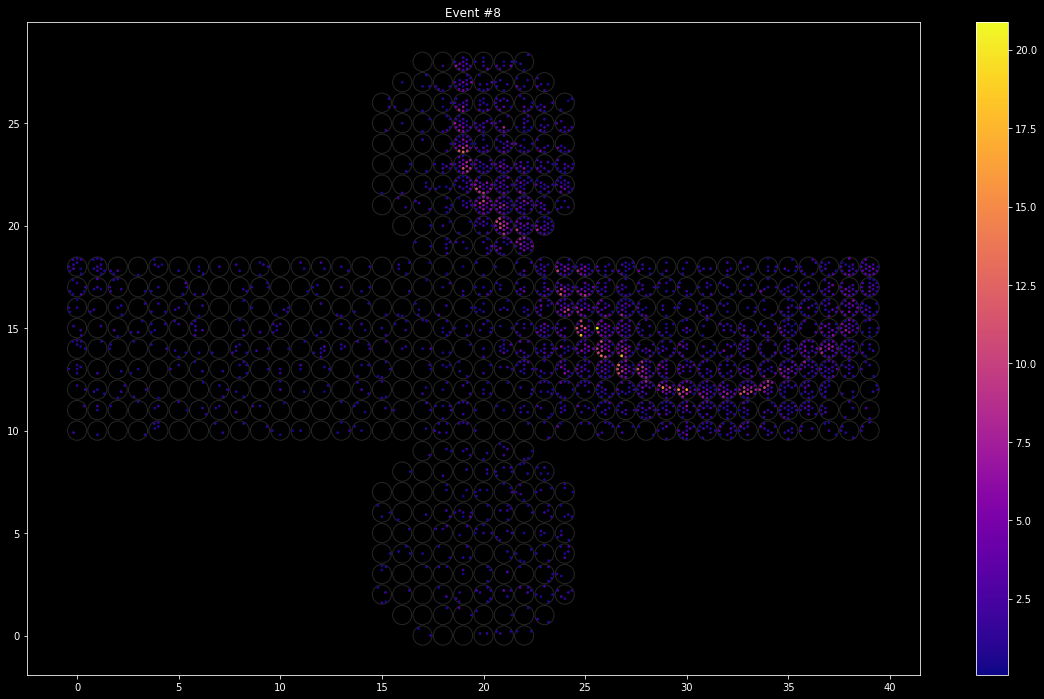

In [25]:
trans = rotation180(data_short, barrel_rows)
plot_event(trans, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma,
        padded=False)

<h3>Testing <Code>rotation180</Code> Transformation</h3>

In [29]:
from watchmal.dataset.cnn_mpmt.transformations import *

In [30]:
sys.modules[rotation180.__module__]

<module 'watchmal.dataset.cnn_mpmt.transformations' from '../../WatChMaL/watchmal/dataset/cnn_mpmt/transformations.py'>

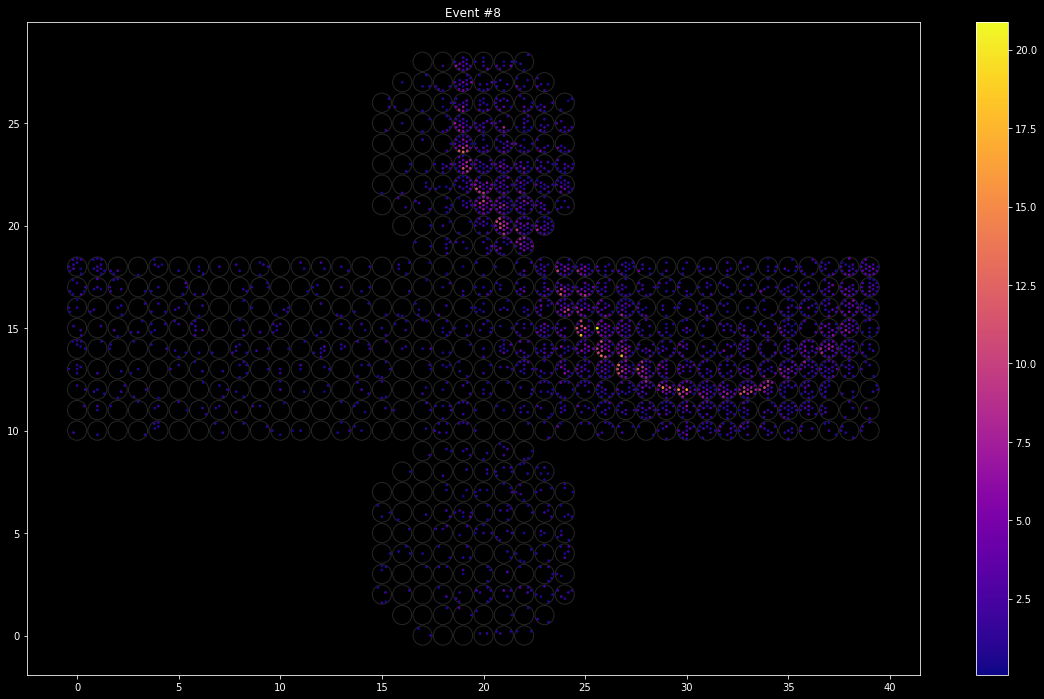

In [31]:
rotated180 = rotation180(data_short, barrel_rows)
plot_event(rotated180, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma,
        padded=False)

<h1>Testing Transformations with Padding</h1>

In [32]:
data_obj_transform = CNNmPMTDataset(data_path, '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz', 
                                    transforms=['horizontal_flip', 'vertical_flip', 'rotation180'],
                                    is_distributed=False)

In [34]:
data_short_transform = data_obj_transform.__getitem__(8)['data']
plot_event(data_short_transform, data_obj_transform.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma,
            padded=False)

TypeError: rotation180() missing 1 required positional argument: 'barrel_rows'

In [35]:
import watchmal.dataset.data_utils as du